Imports

In [ ]:
import random
random.seed(23)
from numpy.random import seed
seed(23)
import tensorflow as tf
tf.random.set_seed(23)

from numpy import array
from string import punctuation
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In/Out functions

In [ ]:
def readData(filePath):
    df = pd.read_csv(filePath)
    # df = df.replace({'Funny': 'Energetic'})
    return df

def writePrediction(results):
    with open('upload_predictions.txt', 'w', encoding = 'utf-8') as fp:
        for x in results:
            fp.write(str(x) + '\n')

In [ ]:
def createTokens(textLyricsList):
    textTokensList = []
    for lyrics in textLyricsList:
        tokens = lyrics.split()
        textTokensList.append(tokens)
    return textTokensList

def cleanTokens(textTokensList):
    cleanTextTokensList = []
    for textTokens in textTokensList:
        translationTable = str.maketrans('', '', punctuation)
        cleanTextTokens = [token.translate(translationTable) for token in textTokens]
        cleanTextTokens = [token for token in cleanTextTokens if token.strip() != '']
        cleanTextTokensList.append(cleanTextTokens)
    return cleanTextTokensList

def filterVacabularyTokens(textTokensList, vocabularySet):
    cleanTextTokensList = []
    for textTokens in textTokensList:
        cleanTextTokens = [token for token in textTokens if token in vocabularySet]
        cleanTextTokensList.append(cleanTextTokens)
    return cleanTextTokensList

def getVocabulary(textTokensList):
    # Creating Vocabulary
    vocabularySet = set()
    for textTokens in textTokensList:
        for token in textTokens:
            vocabularySet.add(token)
    return vocabularySet

def getEncodedData(textTokensList, vocabularySet, mode):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(vocabularySet)
    X = tokenizer.texts_to_matrix(textTokensList, mode=mode)
    return X

Main Code

In [ ]:
# Main Code Start

df = readData('cleaned_lyrics.csv')

In [ ]:
df.groupby('Class').count()

,Artist,Song,Lyrics
Class,,,
Funny,200,200,200
Happy,126,126,126
Motivational,103,103,103
Peaceful,145,145,145
Sad,280,280,280
hate,199,199,199
romantic,230,230,230


In [ ]:
def getModelData(textTokensList, y, vocabularySet, encoding):
    X = getEncodedData(textTokensList, vocabularySet, encoding)
    y = array(y)
    return X, y

def getModelDataTrainTest(trainTextTokensList, testTextTokensList, vocabularySet, encoding):
    Xtrain = getEncodedData(trainTextTokensList, vocabularySet, encoding)
    Xtest = getEncodedData(testTextTokensList, vocabularySet, encoding)

    ytrain = array(train_y)
    ytest = array(test_y)

    return Xtrain, Xtest, ytrain, ytest


def getTrainedModel(Xtrain, ytrain):

    n_words = Xtrain.shape[1]

    model = Sequential()
    model.add(Dense(100, input_shape=(n_words,), activation='relu'))
    model.add(Dense(175, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(175, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(175, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(175, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(175, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(Xtrain, ytrain, epochs=1, verbose=2)

    return model

In [ ]:
def get1vAllReplaceMap(mood):
    moods = ['Happy', 'Sad', 'romantic', 'hate', 'Peaceful', 'Motivational', 'Funny']
    replaceMap = { mood: 1 }
    for m in moods:
        if m != mood:
            replaceMap[m] = 0
    return replaceMap    

In [ ]:
def evaluateModels(train_X_data, test_X_data, train_y_data, test_y_data, vocabularySet):
    moods = ['Happy', 'Sad', 'romantic', 'hate', 'Peaceful', 'Motivational', 'Funny']
    
    models = []
    train_accuracies = []
    test_accuracies = []
    results = []

    train_df = pd.concat((train_X_data, train_y_data), axis=1)
    test_df = pd.concat((test_X_data, test_y_data), axis=1)

    for mood in moods:
        
        replaceMap = get1vAllReplaceMap(mood)

        filtered_train_df = train_df.replace(replaceMap)
        filtered_test_df = test_df.replace(replaceMap)
    
        train_X = filtered_train_df.iloc[:,:3]
        train_y = filtered_train_df.iloc[:,-1]

        test_X = filtered_test_df.iloc[:,:3]
        test_y = filtered_test_df.iloc[:,-1]

        train_lyrics_list = train_X['Lyrics'].tolist()
        trainTextTokensList = createTokens(train_lyrics_list)
        trainTextTokensList = cleanTokens(trainTextTokensList)
        
        test_lyrics_list = test_X['Lyrics'].tolist()
        testTextTokensList = createTokens(test_lyrics_list)
        testTextTokensList = cleanTokens(testTextTokensList)
        testTextTokensList = filterVacabularyTokens(testTextTokensList, vocabularySet)

        Xtrain, ytrain = getModelData(trainTextTokensList, train_y, vocabularySet, 'tfidf')
        Xtest, ytest = getModelData(testTextTokensList, test_y, vocabularySet, 'tfidf')

        model = getTrainedModel(Xtrain, ytrain)
        models.append(model)
        
        loss, test_acc = model.evaluate(Xtest, ytest, verbose=0)
        loss, train_acc = model.evaluate(Xtrain, ytrain, verbose=0)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        results.append([mood + ' vs Not ' + mood, test_acc])

    return moods, models, train_accuracies, test_accuracies, results

X = df.iloc[:,:3]
y = df.iloc[:,-1]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, stratify=y)

train_lyrics_list = train_X['Lyrics'].tolist()
trainTextTokensList = createTokens(train_lyrics_list)
trainTextTokensList = cleanTokens(trainTextTokensList)
vocabularySet = getVocabulary(trainTextTokensList)

moods, models, train_accuracies, test_accuracies, results = evaluateModels(train_X, test_X, train_y, test_y, vocabularySet)

    

29/29 - 2s - loss: 0.3629 - accuracy: 0.9020 - 2s/epoch - 57ms/step
29/29 - 1s - loss: 0.5187 - accuracy: 0.7617 - 1s/epoch - 46ms/step
29/29 - 1s - loss: 0.5203 - accuracy: 0.8007 - 1s/epoch - 45ms/step
29/29 - 1s - loss: 0.4520 - accuracy: 0.8096 - 1s/epoch - 46ms/step
29/29 - 1s - loss: 0.3952 - accuracy: 0.8753 - 1s/epoch - 45ms/step
29/29 - 1s - loss: 0.3793 - accuracy: 0.9198 - 1s/epoch - 44ms/step
29/29 - 1s - loss: 0.3885 - accuracy: 0.8820 - 1s/epoch - 44ms/step


In [ ]:
# results_df.columns = ['Model', 'Train Accuracy', 'Accuracy']
# display(results_df[['Model', 'Accuracy']])
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy'])
display(results_df)
results_df.to_csv('FFNN-tf-idf.csv')
# results_df.columns = ['Model', 'Train Accuracy', 'Accuracy']
# results_df

,Model,Accuracy
0,Happy vs Not Happy,0.901299
1,Sad vs Not Sad,0.781818
2,romantic vs Not romantic,0.820779
3,hate vs Not hate,0.844156
4,Peaceful vs Not Peaceful,0.888312
5,Motivational vs Not Motivational,0.919481
6,Funny vs Not Funny,0.893506


In [ ]:
test_lyrics_list = test_X['Lyrics'].tolist()
testTextTokensList = createTokens(test_lyrics_list)
testTextTokensList = cleanTokens(testTextTokensList)
testTextTokensList = filterVacabularyTokens(testTextTokensList, vocabularySet)

data_lyrics_list = X['Lyrics'].tolist()
dataTextTokensList = createTokens(data_lyrics_list)
dataTextTokensList = cleanTokens(dataTextTokensList)

Xdata, ydata = getModelData(dataTextTokensList, y, vocabularySet, 'tfidf')

Xtrain, ytrain = getModelData(trainTextTokensList, train_y, vocabularySet, 'tfidf')
Xtest, ytest = getModelData(testTextTokensList, test_y, vocabularySet, 'tfidf')

def getPredictedProbabilities(moods, models, X):
    predicted_labels_probability = []
    for mood, model in zip(moods, models):

        yprobabilities = model.predict(X)
        yprobabilities = [y[0] for y in yprobabilities]

        predicted_labels_probability.append(yprobabilities)
    return predicted_labels_probability

train_predicted_labels_probability = getPredictedProbabilities(moods, models, Xtrain)
test_predicted_labels_probability = getPredictedProbabilities(moods, models, Xtest)

data_predicted_labels_probability = getPredictedProbabilities(moods, models, Xdata)


In [ ]:
def getProbabilityAndLabelVectors(predicted_labels_probability):
    predicted_probabilities_transpose =  pd.DataFrame(predicted_labels_probability).T.values.tolist()

    probability_df = pd.DataFrame(predicted_probabilities_transpose, columns=['Happy', 'Sad', 'romantic', 'hate', 'Peaceful', 'Motivational', 'Funny'])
    display(probability_df)

    ytest_hat_labels_for1vAll = []
    for probabilities in predicted_probabilities_transpose:
        predicted_moods = []
        for i, mood_prob in enumerate(probabilities):
            if mood_prob < 0.5:
                predicted_moods.append(0)
            else:
                predicted_moods.append(1)

        if 1 not in predicted_moods:
            predicted_moods[np.argmax(probabilities)] = 1
        ytest_hat_labels_for1vAll.append(predicted_moods)

    labels_df = pd.DataFrame(ytest_hat_labels_for1vAll, columns=['Happy', 'Sad', 'romantic', 'hate', 'Peaceful', 'Motivational', 'Funny'])
    display(labels_df)

    return predicted_probabilities_transpose, ytest_hat_labels_for1vAll


train_predicted_probabilities_transpose, train_labels_for1vAll = getProbabilityAndLabelVectors(train_predicted_labels_probability)
test_predicted_probabilities_transpose, test_labels_for1vAll = getProbabilityAndLabelVectors(test_predicted_labels_probability)

data_predicted_probabilities_transpose, data_labels_for1vAll = getProbabilityAndLabelVectors(data_predicted_labels_probability)

  

,Happy,Sad,romantic,hate,Peaceful,Motivational,Funny
0,0.067635,0.226017,0.050166,0.081293,5.433927e-06,0.001263,0.256270
1,0.104155,0.252461,0.236007,0.288053,1.996922e-02,0.077675,0.026393
2,0.075758,0.191119,0.092943,0.421903,4.665852e-04,0.049611,0.267812
3,0.376652,0.233108,0.128397,0.178368,6.122708e-03,0.054017,0.157631
4,0.014559,0.020561,0.008305,0.105131,2.980919e-08,0.000636,0.860824
...,...,...,...,...,...,...,...
893,0.275336,0.263529,0.152561,0.214045,1.347274e-03,0.037232,0.030628
894,0.125666,0.376301,0.240593,0.447602,3.215021e-02,0.125602,0.094017
895,0.031912,0.317045,0.322569,0.341330,2.414307e-02,0.056662,0.016512
896,0.169761,0.278922,0.245155,0.150336,1.025343e-02,0.033266,0.118754


,Happy,Sad,romantic,hate,Peaceful,Motivational,Funny
0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
893,1,0,0,0,0,0,0
894,0,0,0,1,0,0,0
895,0,0,0,1,0,0,0
896,0,1,0,0,0,0,0


,Happy,Sad,romantic,hate,Peaceful,Motivational,Funny
0,9.889618e-02,0.439914,3.121524e-01,0.121389,2.779835e-02,1.085714e-01,0.029955
1,1.523832e-01,0.426892,2.978668e-01,0.361924,4.187116e-02,8.097142e-02,0.066883
2,1.079247e-01,0.395661,2.390532e-01,0.224905,2.452213e-02,2.115399e-02,0.042420
3,1.060415e-01,0.232150,1.319154e-01,0.312779,4.119188e-03,3.117397e-02,0.173492
4,6.157287e-08,0.000032,1.119476e-09,0.023342,7.265649e-31,1.001165e-14,0.999638
...,...,...,...,...,...,...,...
380,1.088282e-02,0.047265,2.255359e-02,0.342494,5.937182e-06,4.623348e-02,0.553832
381,2.061583e-01,0.300009,2.369739e-01,0.435512,1.496577e-02,1.035069e-01,0.123132
382,1.329168e-01,0.328056,2.581671e-01,0.304081,1.680240e-02,4.919440e-02,0.079216
383,2.758847e-01,0.377744,2.440341e-01,0.231952,5.996650e-02,1.509551e-01,0.469533


,Happy,Sad,romantic,hate,Peaceful,Motivational,Funny
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
380,0,0,0,0,0,0,1
381,0,0,0,1,0,0,0
382,0,1,0,0,0,0,0
383,0,0,0,0,0,0,1


,Happy,Sad,romantic,hate,Peaceful,Motivational,Funny
0,1.715094e-01,3.572400e-01,2.791110e-01,0.369512,4.562208e-02,1.457866e-01,0.487521
1,3.766524e-01,2.331080e-01,1.283967e-01,0.178368,6.122708e-03,5.401742e-02,0.157631
2,1.103899e-01,1.292517e-01,3.164127e-01,0.196807,1.779830e-02,5.315673e-02,0.016311
3,3.418221e-01,3.212103e-01,2.084369e-01,0.153763,7.638454e-03,6.132439e-02,0.122480
4,2.593314e-01,1.992895e-01,2.559516e-01,0.196088,5.052894e-03,1.076837e-01,0.017329
...,...,...,...,...,...,...,...
1278,1.734275e-02,1.156966e-01,1.135409e-02,0.035301,1.514120e-05,1.564533e-03,0.762073
1279,1.410284e-05,3.232292e-05,3.091328e-08,0.021870,1.133295e-24,3.642344e-11,0.998083
1280,1.254062e-07,1.514440e-05,4.848712e-10,0.002114,3.299714e-31,9.151206e-16,0.999963
1281,7.585406e-03,4.249704e-02,9.760648e-03,0.073127,3.212167e-07,6.522834e-04,0.856400


,Happy,Sad,romantic,hate,Peaceful,Motivational,Funny
0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1278,0,0,0,0,0,0,1
1279,0,0,0,0,0,0,1
1280,0,0,0,0,0,0,1
1281,0,0,0,0,0,0,1


,Artist,Song,Lyrics
1194,Aeschylus,Agamemnon (Full Text),palace statue god altar prepare sacrifice nigh...
802,Sugarland,Stuck Like Glue,mmm well absolutely know well feel good stay l...
603,Alice in Chains,Hate to Feel,go wrong straight long hate fuck drown wake s...
1,Bobby McFerrin,Don't Worry Be Happy,little song write want sing note note worry ha...
1101,B-Ly & WillFake,Calling The Targets,lookin ambidextrous knife throat cut clap clap...
...,...,...,...
15,Frente!,Open Up Your Heart And Let The Sun Shine In,little kid know devil learn hate say cause tro...
447,Pantera,This Love,word speak painful untrue say love lie life wa...
759,Edward Maya,Stereo Love,going to stop break heart wanna pray thing let...
789,Thomas Rhett,Die a Happy Man,baby night hand good night doubt bottle wine l...


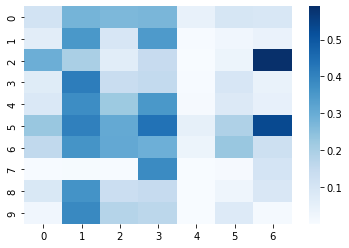

In [ ]:
display(train_X)
import seaborn as sns

sns.heatmap(train_predicted_probabilities_transpose[50:60], cmap="Blues")

In [ ]:
data_df = pd.concat((X,y), axis=1)
data_df = data_df.drop(['Lyrics'], axis=1)
data_df['probability_vector'] = data_predicted_probabilities_transpose
data_df['label_vector'] = data_labels_for1vAll

data_df.to_csv('prob_vec.csv')

